In [1]:
from osgeo import gdal
from osgeo import osr
import h5py as h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [2]:
def create_tif(destName, array, fill_value, rows, cols, top_left_x, top_left_y, x_step, y_step, epsg, rotation=0):
    """
    function to create tif file
    """
    
    # Create output tiff file.
    # driver.Create() parameters are: output path, number of columns, number of rows,
    # number of bands, data type
    driver = gdal.GetDriverByName("GTiff")
    out_tif = driver.Create(destName, cols, rows, 1, gdal.GDT_Float32)

    # Create Spatial Reference object and set GeoTIFF projection.
    # This information may be found in either the data documentation or the netCDF file.
    prj = osr.SpatialReference()
    prj.ImportFromEPSG(epsg) # WGS84
    out_tif.SetProjection(prj.ExportToWkt())

    # Set GeoTransformation.
    # This information may be found in either the data documentation, the netCDF file, or
    # can be derived. For example, if you know the longitude range and number of columns
    # you can calculate the x step as float(lon_range)/float(num_cols).
    geotrans = [top_left_x, x_step, rotation, top_left_y, rotation, y_step]
    out_tif.SetGeoTransform(geotrans)

    # Finally we can write the array to the raster band.
    out_band = out_tif.GetRasterBand(1)    
    out_band.SetNoDataValue(fill_value)
    out_band.WriteArray(array)

    # Clear the memory and close the output file.
    out_tif.FlushCache()
    out_tif = None

In [3]:
# open KNMI h5 file
hdf_file = r'D:\jupyter notebooks\3717.30 KNMI H5 bestanden\RAD_NL25_PCP_CM_201809140245.h5'
dataset = h5py.File(hdf_file, 'r')

Beschrijving van de mogelijke items in een KNMI HDF5 bestand:

Bron: http://projects.knmi.nl/datacentrum/catalogus/catalogus/content/hdftag3-5.pdf

____

The following groups are the minimal required content of the KNMI HDF5 files.

#### Overview group

This group provides an overview of the dataset. It contains references, identifiers, a quicklook and fields describing the content of the file.

#### Geographic group
All information about the geographic reference of the dataset is placed in this group. This includes map projection and parameters used in this operation.

#### Image group
This group forms the core of a HDF5 image file. It contains most relevant image information. The
image data (pixel values) itself and metadata about the image are placed in this group. There can be more than one image group in one HDF5 file. In the KNMI HDF5 implementation the following rules for the storage of multiple image-layers are defined: 

One HDF5 file can only contain multiple images (2D arrays) in case these images all have the same geographical properties (spatial resolution, area coverage and map projection). This implies that the images, stored in one HDF5 file, all have an equal number of pixel columns and rows.

#### Radar group
In this group, all relevant information regarding the radar systems is placed. This includes the position of the radar systems at the time of data capturing. Orbit prediction data are included here. Also descriptions of the on-board instruments/sensors can be placed here (e.g.spectral bands related to channels, etc.). If data of more than one satellite is included in the HDF5 file then more radar systems groups will be included in the file.

In [4]:
# print the keys
for key in dataset.keys():
    print(key)

geographic
image1
overview
radar1
radar2
radar3
visualisation1


In [5]:
# read all metadata from all key groups
metadata = {}
for key in dataset.keys():
    metadata[key] = dict()
    for attr_name in dataset[key].attrs:
        # convert item to unicode
        attr_item = dataset[key].attrs[attr_name].astype('U13')
        # add to dictionary
        metadata[key].update({attr_name: attr_item})

# pretty print the metadata
print(json.dumps(metadata, sort_keys=True, indent=2, cls=NumpyEncoder))        

{
  "geographic": {
    "geo_column_offset": [
      "0.0"
    ],
    "geo_dim_pixel": "KM,KM",
    "geo_number_columns": [
      "700"
    ],
    "geo_number_rows": [
      "765"
    ],
    "geo_par_pixel": "X,Y",
    "geo_pixel_def": "LU",
    "geo_pixel_size_x": [
      "1.0000035"
    ],
    "geo_pixel_size_y": [
      "-1.0000048"
    ],
    "geo_product_corners": [
      "0.0",
      "49.362064",
      "0.0",
      "55.973602",
      "10.856453",
      "55.388973",
      "9.0093",
      "48.8953"
    ],
    "geo_row_offset": [
      "3649.982"
    ]
  },
  "image1": {
    "image_bytes_per_pixel": [
      "1"
    ],
    "image_cloud_mask_applied": "1",
    "image_geo_parameter": "REFLECTIVITY_",
    "image_product_name": "RAD_NL25_PCP_",
    "image_size": [
      "535500"
    ]
  },
  "overview": {
    "hdftag_version_number": "3.6",
    "number_image_groups": [
      "1"
    ],
    "number_radar_groups": [
      "3"
    ],
    "number_satellite_groups": [
      "0"
    ],
    "nu

In [6]:
# undocumented fill_value, but retrieved from image
fill_value = 255 # in other KNMI h5 files this has been the value 65535

# get data
precip = dataset['image1/image_data'][:]

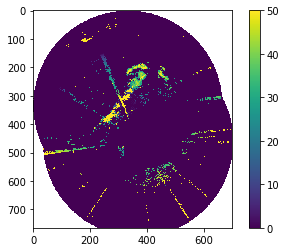

In [7]:
# set fill value
precip_ma = np.ma.masked_where(precip==fill_value, precip)

im = plt.imshow(precip_ma, vmin=0, vmax=50)
plt.colorbar(im)
plt.show()

#### Following describes how to save the array to EPSG:29882 geotiff

In [8]:
# get array dimensions
cols = int(metadata['geographic']['geo_number_columns'][0])
rows = int(metadata['geographic']['geo_number_rows'][0])

# get top-left coordinate + stepsize
top_left_lon = float(metadata['geographic']['geo_product_corners'][0])
top_left_lat = float(metadata['geographic']['geo_product_corners'][3])

#### Definition of order of geo_product_corners
(in Geographic group). The first corner is always the southwest corner. Then northwest, northeast and southeast. In earlier versions it was defined as lowerleft, upperleft, etc.

[..]

Latitude and longitude of each of the four product corners (starting with
southwest corner and then clockwise)

In [11]:
# strange file format, corners are defined in lat/lon, 
# while pixels are measured in kilometers
# convert corner to RD (epsg:28992) so we can use pixel size from metadata
prj_in = osr.SpatialReference() #spatial reference - from
prj_in.ImportFromEPSG(4326) #wgs latlon
prj_in.ExportToWkt()

prj_out = osr.SpatialReference() #spatial reference - to
prj_out.ImportFromEPSG(28992) #wgs utm 21S
prj_out.ExportToWkt()

prj_transform = osr.CoordinateTransformation(prj_in, prj_out)
point_transform = prj_transform.TransformPoint(top_left_lon, top_left_lat)

top_left_x = point_transform[0]
top_left_y = point_transform[1]

#### Definition of geo_dim_pixel
Dimensions of image pixel size (horizontal,vertical) e.g. “KM,KM”

In [ ]:
# raw pixel information from metadata is in KM
# print(metadata['geopgraphic']['geo_dim_pixel'])
x_step_raw = float(metadata['geographic']['geo_pixel_size_x'][0])
y_step_raw = float(metadata['geographic']['geo_pixel_size_y'][0])
rotation = 0

# since epsg:28992 is measured in meters also convert pixel to meter
x_step = x_step_raw * 1000
y_step = y_step_raw * 1000

In [ ]:
# create tmp file directory
path_out = os.path.join(r'D:\jupyter notebooks\3717.30 KNMI H5 bestanden','RAD_NL25_PCP_CM_201809140245.tif')
print('hdf as tif : {0}'.format(path_out))

In [ ]:
# write to tif in epsg 28992 projection
epsg = 28992
create_tif(path_out, precip, fill_value, rows, cols, top_left_x, top_left_y, x_step, y_step, epsg=epsg)